<a href="https://colab.research.google.com/github/ankit-kothari/Data-Science-Journey/blob/master/suicide_risk_prediction_all_label_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers 
!pip install dask
!pip install 'fsspec>=0.3.3'
!pip install datasets
!pip install torchinfo

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [3]:
from transformers import pipeline
import torch
import spacy
import tqdm as notebook_tqdm
from torchinfo import summary
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,roc_auc_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import  matplotlib.pyplot as plt
from datasets import load_dataset
from spacy.lang.en import English
import warnings
from tqdm import tqdm
import re
import string
warnings.filterwarnings("ignore")
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import concurrent.futures
import dask.bag as db
import dask 
import graphviz
from dask import visualize

#nlp = spacy.load('en_core_web_sm')

from collections import defaultdict

from tqdm import tqdm # Runtime progress bar

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Loading the Data

In [4]:
stopwords_file = "/content/drive/Shareddrives/MSML641 Project/msml_641_ankit_sandeep_final_submission/FILE FOR THE PROJECT/mallet_en_stoplist.txt"
train_post = '/content/drive/Shareddrives/MSML641 Project/msml_641_ankit_sandeep_final_submission/FILE FOR THE PROJECT/task_A_train_posts.csv'
train_label = '/content/drive/Shareddrives/MSML641 Project/msml_641_ankit_sandeep_final_submission/FILE FOR THE PROJECT/crowd_train.csv'

test_post= '/content/drive/Shareddrives/MSML641 Project/msml_641_ankit_sandeep_final_submission/FILE FOR THE PROJECT/task_A_test_posts.csv'
test_label= '/content/drive/Shareddrives/MSML641 Project/msml_641_ankit_sandeep_final_submission/FILE FOR THE PROJECT/crowd_test_A.csv'

valid_post = '/content/drive/Shareddrives/MSML641 Project/msml_641_ankit_sandeep_final_submission/FILE FOR THE PROJECT/expert.csv'
valid_label= '/content/drive/Shareddrives/MSML641 Project/msml_641_ankit_sandeep_final_submission/FILE FOR THE PROJECT/expert.csv'

shared_posts_train = '/content/drive/Shareddrives/MSML641 Project/msml_641_ankit_sandeep_final_submission/FILE FOR THE PROJECT/shared_task_posts.csv'
shared_posts_test = '/content/drive/Shareddrives/MSML641 Project/msml_641_ankit_sandeep_final_submission/FILE FOR THE PROJECT/shared_task_posts_test.csv'


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### NLP Helper Functions

In [6]:
def load_stopwords(filename):
    stopwords = [] 
    with open(filename, "r") as f:
      stopwords = [] 
      for line in tqdm(f):
        line = re.sub(r"\n","",line, flags=re.I)
        stopwords.append(line)
      return set(stopwords)

stopwords= load_stopwords(stopwords_file)
nlp = English(parser=False)
def spacy_preprocessing(text):
    '''
    text: accepts stings text
    stopwords: list of stopwords
    proceduralwords: list of procedural words in politics
    exclude_list: Custom list of words to include ex: ['mr','managers']
    clean_tokens: maps words like you're to you are
    returns a clean string

    Parameters
    remove_punctuations: yes removes all puntuations
    remove_stopwords:  yes removes all stopwords
    remove_nonalpha: yes removes all characters execpt uppercase and lowercase letters
    Example: text = text = "I am soooooo excited Mr. , to learn nlp. s123 2003 you're doing      great. He will be awesome!!   managers for life"

    '''
    
    exclude_list=[]
    remove_punctuations='yes'
    remove_stopwords='yes'
    remove_nonalpha='yes'

    #removing any websit
    text = re.sub(r"http[s]://[a-zA-Z.\/0-9?=]*\b", "", text)
    # replaces single random characters in the text with space
    text = re.sub(r"\b([a-zA-Z]{1})\b", " ", text)
    # replaces special characters with spaces
    if remove_nonalpha == 'yes':
        text = re.sub(r"[^a-zA-Z]", " ", text)
    # replaces multiple character with a word with one like pooooost will be post
    text = re.sub(r"(.)\1{3,}", r"\1", text)
    # replaces multiple space in the line with single space
    text = re.sub(r"\s{2,}", r" ", text)

    clean_text = []
    
    doc = nlp(text)
    for token in doc:
        if (remove_punctuations == 'yes') & (remove_stopwords == 'yes'):
            if (token.orth_ not in string.punctuation) & (token.orth_.lower() not in stopwords) & (token.orth_.lower() not in exclude_list):
                clean_text.append(token.orth_.lower())
        elif (remove_punctuations == 'yes') & (remove_stopwords == 'no'):
            if (token.orth_ not in string.punctuation):
                clean_text.append(token.orth_.lower())
        elif (remove_punctuations == 'no') & (remove_stopwords == 'yes') & (token.orth_.lower() not in exclude_list):
            if (token.orth_ not in stopwords) & (
                    token.orth_ not in string.punctuation):
                clean_text.append(token.orth_.lower())
        else:
            clean_text.append(token.orth_.lower())
            continue
    clean_string = " ".join(clean_text).lstrip()
    return clean_string

def normalize_tokens(tokenlist):
    '''
    Input: list of tokens as strings,  e.g. ['I', ' ', 'saw', ' ', '@psresnik', ' ', 'on', ' ','Twitter']
    Output: list of tokens where
    All tokens are lowercased
    All tokens starting with a whitespace character have been filtered out
    All handles (tokens starting with @) have been filtered out
    Any underscores have been replaced with + (since we use _ as a special character in bigrams)
    '''
    normalized_tokens = [token.lower().replace('_','+') for token in tokenlist   # lowercase, _ => +
                             if re.search('[^\s]', token) is not None            # ignore whitespace tokens
                             and not token.startswith("@")                       # ignore  handles
                        ]
    return normalized_tokens


524it [00:00, 757.62it/s]


### Data Pre-Processing

In [7]:
def load_data(post_A_file, label_file, shared_posts_file):
  data = pd.read_csv(post_A_file)
  print(
    f'The Shape Task A file containg data for r/sucudiewatch channel is {data.shape}'
  )
  print(f'Unique User Ids {data.user_id.nunique()}')
  data_labels = pd.read_csv(label_file)
  #data_labels=data_labels.dropna()
  print(f'The user-id --> label mapping file {data_labels.shape}')
  print(
    f'The distribution of labels in the the dataset \n{data_labels.label.value_counts()}'
  )
  posts = pd.read_csv(shared_posts_file)
  merged_data = pd.DataFrame()
  merged_data = posts.merge(data, how='inner', left_on='post_id',right_on='post_id',validate='one_to_many')
  merged_data.drop(columns=['user_id_y','subreddit_y'],inplace=True)
  merged_data.columns=['post_id', 'user_id', 'timestamp', 'subreddit', 'post_title','post_body']
  merged_labeled_data = merged_data.merge(data_labels, how='inner',left_on='user_id',right_on='user_id')
  merged_labeled_data.dropna(subset=['post_body'],inplace=True)
  merged_labeled_data.drop(columns=['post_id','subreddit'],inplace=True)
  return merged_labeled_data

In [8]:
train_data = load_data(train_post, train_label, shared_posts_train)

The Shape Task A file containg data for r/sucudiewatch channel is (919, 3)
Unique User Ids 496
The user-id --> label mapping file (993, 2)
The distribution of labels in the the dataset 
d    206
a    127
c    113
b     50
Name: label, dtype: int64


In [9]:
test_data = load_data(test_post, test_label, shared_posts_test)

The Shape Task A file containg data for r/sucudiewatch channel is (186, 3)
Unique User Ids 125
The user-id --> label mapping file (125, 2)
The distribution of labels in the the dataset 
d    52
a    32
c    28
b    13
Name: label, dtype: int64


In [10]:
%%timeit
#Convert the list to a Dask bag
reviews_list = train_data['post_body'].to_list()
review_bag = db.from_sequence(reviews_list, npartitions=3)
clean_body_train = review_bag.map(spacy_preprocessing)
train_data['clean_body'] =clean_body_train.compute()

9.49 s ± 1.34 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
train_data.head()

user_id   timestamp  \
0    22002  1406494593   
1    22006  1395339794   
2    22015  1337230954   
3    22134  1310621370   
6    22134  1343885091   

                                                             post_title  \
0                          Yesterday i turned off cigarette in my hand.   
1                                              Not sure what to do now.   
2  I despise sounding so pathetically melodramatic, but I'm just tired.   
3                                                     You guys saved me   
6                                                           Back again.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

#### Cleeaning the Data

In [12]:
%%timeit
#Convert the list to a Dask bag
reviews_list_test = test_data['post_body'].to_list()
review_bag_test = db.from_sequence(reviews_list_test, npartitions=3)
clean_body_test = review_bag_test.map(spacy_preprocessing)
test_data['clean_body'] =clean_body_test.compute()

8.24 s ± 1.57 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
def data_preprocessing(df):
  df['rank'] = df.groupby(["user_id"])["timestamp"].rank("dense", ascending=False)
  df = df.query('rank<=3')
  agg_user_comment = df.groupby(['user_id','label'], as_index=False)['clean_body'].agg(['unique']).reset_index()
  sentencs = pd.DataFrame(agg_user_comment['unique'].to_list(), columns = ['sent1', 'sent2', 'sent3'])
  combined = pd.concat([agg_user_comment['label'],sentencs ], axis=1)
  combined['length']=combined['sent1'].apply(lambda x: len(x.split(' ')))
  combined = combined.query('length>20')
  combined.drop(columns=['length'], inplace=True)
  return combined


In [14]:
train_df = data_preprocessing(train_data)
test_df = data_preprocessing(test_data)


In [15]:
train_df = train_df.fillna(value=-100)
test_df = test_df.fillna(value=-100)

In [16]:
train_df.head(2)

,label,sent1,sent2,sent3
0,d,stuck hate confidence abilities future stuck dead end job badly time university courses technical career choke terrified confidence ll state don rest life thing keeping alive fact don put parents son killing future hopeless bleak confident skills change dying easier failing change,things depressed suicide disappearing living totally grid viable option future uncertain bleak terrifying give feel,-100
2,c,background white male college graduate enroll graduate program job enroll masters program afraid dying thought suicide comforting recently occupies bit thoughts kill gunshot overdose ready access thing prevents arm love mom massive support system source love hate disappoint leave conclusion stay alive eventually passes case reason carry shallow selfish weighs ton bricks thinks ahead wouldn worry emotions product perception couldn dead don joy things anymore ve started burnt job enjoy school people distract good feels hole extremely unhappy end rant,-100,-100


In [17]:
test_df.head(2)

,label,sent1,sent2,sent3
0,d,haven felt years jsut deal anymore absolutely closest friend doesn anymore thinks boyfriend cheating methe guy doesn talk anymore dfucking boring crazy nt nt care knowi iti die nt anymore wash oit wine liquor cover smile donei ca nt anymore,-100,-100
1,d,months cousin told doesn live anymore made pact birthday happy kill birthday tomorrow ve thing stayed night talking nights texted week sitting van rope ready girlfriend contacted goodbye message scared person talk talk managed home sleep ringing dad ringing suicide line rang speak cliff area days ago sat hours contemplating jumping sat person change mind doesn feel change mind ve begged doctors faith ve begged speak dad scared losing scared turning family upside scared break uncle aunties heart terrified live guilt hope doesn guess needed speak mind strangers,-100,-100


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386 entries, 0 to 495
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   386 non-null    object
 1   sent1   386 non-null    object
 2   sent2   386 non-null    object
 3   sent3   386 non-null    object
dtypes: object(4)
memory usage: 15.1+ KB


In [19]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 124
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   101 non-null    object
 1   sent1   101 non-null    object
 2   sent2   101 non-null    object
 3   sent3   101 non-null    object
dtypes: object(4)
memory usage: 3.9+ KB


In [20]:
target_map = {'a': 0,  'b': 1,'c':2,'d':3}
train_df['label']=train_df['label'].map(target_map)
test_df['label']=test_df['label'].map(target_map)
train_df['label'] = train_df['label'].astype('int32')
test_df['label'] = test_df['label'].astype('int32')

#### Saving the pre-processed file

In [21]:
train_df.to_csv('/content/drive/MyDrive/data/sr_train.csv')
test_df.to_csv('/content/drive/MyDrive/data/sr_test.csv')

### Hugging Face Creating Dataset Object

In [22]:
raw_datasets = load_dataset(
    'csv',
    data_files={'train':'/content/drive/MyDrive/data/sr_train.csv',
                'test':'/content/drive/MyDrive/data/sr_test.csv'}
)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c11ef48f099478a9/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [23]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'label', 'sent1', 'sent2', 'sent3'],
        num_rows: 386
    })
    test: Dataset({
        features: ['Unnamed: 0', 'label', 'sent1', 'sent2', 'sent3'],
        num_rows: 101
    })
})

In [24]:
raw_datasets['train']['sent1'][0]

'stuck hate confidence abilities future stuck dead end job badly time university courses technical career choke terrified confidence ll state don rest life thing keeping alive fact don put parents son killing future hopeless bleak confident skills change dying easier failing change'

In [25]:
raw_datasets['test']['sent1'][0]

'haven felt years jsut deal anymore absolutely closest friend doesn anymore thinks boyfriend cheating methe guy doesn talk anymore dfucking boring crazy nt nt care knowi iti die nt anymore wash oit wine liquor cover smile donei ca nt anymore'

### Tokenizer

In [26]:
from transformers import AutoTokenizer

In [27]:
checkpoint ="roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [28]:
tokenizer

PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})

In [29]:
def tokenize_fn(batch):
  return tokenizer(batch['sent1'],batch['sent2'], truncation=True, padding=True, max_length=512)

tokenized_dataset = raw_datasets.map(tokenize_fn, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [30]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'label', 'sent1', 'sent2', 'sent3', 'input_ids', 'attention_mask'],
        num_rows: 386
    })
    test: Dataset({
        features: ['Unnamed: 0', 'label', 'sent1', 'sent2', 'sent3', 'input_ids', 'attention_mask'],
        num_rows: 101
    })
})

In [31]:
tokenized_dataset['train']['input_ids'][0][0:10]

[0, 620, 5858, 4157, 2123, 11360, 499, 4889, 1462, 253]

In [32]:
#tokenized_dataset['train']['token_type_ids'][0][0:10]

In [77]:
tokenized_dataset['train']['label'][0:3]

0    3
1    2
2    3
Name: label, dtype: int64

In [34]:
tokenizer.decode(tokenized_dataset['train']['input_ids'][0])

'<s>stuck hate confidence abilities future stuck dead end job badly time university courses technical career choke terrified confidence ll state don rest life thing keeping alive fact don put parents son killing future hopeless bleak confident skills change dying easier failing change</s></s>things depressed suicide disappearing living totally grid viable option future uncertain bleak terrifying give feel</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

### Config File for the Model 

In [35]:
from torch import nn 
from transformers import AutoConfig

num_labels=4
config = AutoConfig.from_pretrained(checkpoint, num_labels=num_labels)

In [37]:
target_map = {'a': 0,  'b': 1,'c':2,'d':3}

In [38]:
config.id2label = {v:k for k,v in target_map.items()}
config.id2label

{0: 'a', 1: 'b', 2: 'c', 3: 'd'}

In [39]:
config.label2id = target_map
config.label2id

{'a': 0, 'b': 1, 'c': 2, 'd': 3}

In [40]:
config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "a",
    "1": "b",
    "2": "c",
    "3": "d"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "a": 0,
    "b": 1,
    "c": 2,
    "d": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

### Loading the Model for Classification

In [41]:
from transformers import AutoModelForSequenceClassification
import torch

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification.from_pretrained("roberta-base", config=config).to(device))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [43]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

### Testing Model

In [44]:
##tokenized data 
sample_text1 = raw_datasets['train']['sent1'][0]
sample_text2 = raw_datasets['train']['sent2'][0]
sample = tokenizer(sample_text1, truncation=True,padding=True, return_tensors='pt',max_length=512)
sample.keys()

dict_keys(['input_ids', 'attention_mask'])

In [45]:
#model.resize_token_embeddings(len(tokenizer))

In [46]:
tokenizer.decode(sample['input_ids'][0])

'<s>stuck hate confidence abilities future stuck dead end job badly time university courses technical career choke terrified confidence ll state don rest life thing keeping alive fact don put parents son killing future hopeless bleak confident skills change dying easier failing change</s>'

In [47]:
sample_label = raw_datasets['train']['label'][0]
print(f'sample label {sample_label}')
sample_label = torch.tensor(sample_label, dtype=torch.long)
type(sample_label)

sample label 3


torch.Tensor

In [48]:
preds_distilebert= model(sample['input_ids'].to(device))
preds_distilebert

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.1006,  0.0725, -0.1889,  0.2362]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

### Training Arguments

In [49]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification
## Training Arguments
batch_size= 16
logging_steps = len(tokenized_dataset["train"]) // batch_size
model_name = "suicide_risk_analysis_model"
training_args = TrainingArguments(
    'suicide_risk_model_preediction',
    evaluation_strategy='epoch',
    num_train_epochs=6,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_strategy='epoch',
    logging_steps=logging_steps,
    log_level="error",
    push_to_hub=False,
    disable_tqdm=False
    )

### Compute Metric Function

In [50]:
def compute_metrics(pred):
  labels=pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels,preds, average="weighted"),
  acc = accuracy_score(labels,preds)
  return {"accuracy":acc,"f1":f1}

### Trainer Object

In [51]:
from transformers import Trainer 
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset = tokenized_dataset['test'],
                  tokenizer=tokenizer)

### Training 

In [52]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.323900,1.244522,0.435644,"(0.26439057698873336,)"
2,1.212000,1.200805,0.435644,"(0.26439057698873336,)"
3,1.228600,1.164039,0.564356,"(0.4589206746761633,)"
4,1.172900,1.117435,0.534653,"(0.45692777189134376,)"
5,1.063800,1.138265,0.554455,"(0.4958040760744346,)"
6,1.066600,1.111316,0.534653,"(0.4386350915793334,)"


TrainOutput(global_step=150, training_loss=1.1699576663970948, metrics={'train_runtime': 109.5156, 'train_samples_per_second': 21.148, 'train_steps_per_second': 1.37, 'total_flos': 609376146702336.0, 'train_loss': 1.1699576663970948, 'epoch': 6.0})

### Loading in the Checkpoints

In [53]:
!ls -ltra suicide_risk_model_preediction

total 36
drwxr-xr-x 1 root root 4096 Aug 24 01:40 ..
drwxr-xr-x 3 root root 4096 Aug 24 01:40 runs
drwxr-xr-x 2 root root 4096 Aug 24 01:40 checkpoint-25
drwxr-xr-x 2 root root 4096 Aug 24 01:41 checkpoint-50
drwxr-xr-x 2 root root 4096 Aug 24 01:41 checkpoint-75
drwxr-xr-x 2 root root 4096 Aug 24 01:41 checkpoint-100
drwxr-xr-x 2 root root 4096 Aug 24 01:42 checkpoint-125
drwxr-xr-x 9 root root 4096 Aug 24 01:42 .
drwxr-xr-x 2 root root 4096 Aug 24 01:42 checkpoint-150


### Creating a Pipeline for Prediction

In [ ]:
from transformers import pipeline

In [55]:
#loading the trained model with a specific checkpoint
savedmodel = pipeline('text-classification',
                      model='suicide_risk_model_preediction/checkpoint-125',
                      device=0)

In [58]:
test_pred = savedmodel(raw_datasets['test']['sent1'],raw_datasets['test']['sent2'])
test_inx = [target_map[k['label']] for k in test_pred]
test_inx[0:2]

[3, 0]

### Model Evaluation

In [59]:
cm = confusion_matrix(raw_datasets['test']['label'], test_inx, labels=[0, 1,2,3])

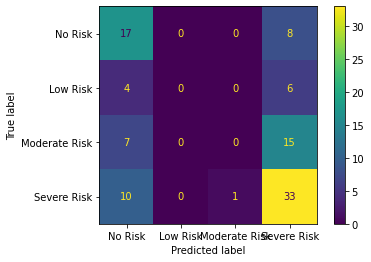

In [60]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['No Risk', 'Low Risk','Moderate Risk','Severe Risk'])
disp.plot()
plt.grid(False)
plt.show()

In [61]:
print(classification_report(raw_datasets['test']['label'], test_inx))

              precision    recall  f1-score   support

           0       0.45      0.68      0.54        25
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        22
           3       0.53      0.75      0.62        44

    accuracy                           0.50       101
   macro avg       0.24      0.36      0.29       101
weighted avg       0.34      0.50      0.40       101



### Error Analysis

In [63]:
f"suicide_risk_model_preediction/checkpoint-125"

'suicide_risk_model_preediction/checkpoint-125'

In [64]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [65]:
from torch.nn.functional import cross_entropy
def forward_pass_with_custom_model(batch):
    #place all input tensors on the device 
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    #call the model
    with torch.no_grad():
        outputs = model(input_ids=inputs["input_ids"].to(device) , attention_mask=inputs["attention_mask"].to(device), labels=batch["label"].to(device))
        #get the logits
        logits = outputs.logits
        pred_labels = logits.argmax(-1)
        loss = cross_entropy(logits, batch["label"].to(device), reduction="none") #shape of logits is (batch_size, num_labels) and shape of batch["label"] is (batch_size)
        #place the outputs on the CPU for compatibility with the other dataset columns  
        return {"pred_labels": pred_labels.cpu().numpy(),"batch_loss": loss.cpu().numpy() }

In [66]:
#convert dataset to pytocrch tensors
tokenized_dataset.set_format("torch", columns=["input_ids","attention_mask" ,"label"])
#Compute loss values
tokenized_dataset["test"] = tokenized_dataset["test"].map(forward_pass_with_custom_model, batched=True, batch_size=16)

  0%|          | 0/7 [00:00<?, ?ba/s]

In [67]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'label', 'sent1', 'sent2', 'sent3', 'input_ids', 'attention_mask'],
        num_rows: 386
    })
    test: Dataset({
        features: ['Unnamed: 0', 'label', 'sent1', 'sent2', 'sent3', 'input_ids', 'attention_mask', 'pred_labels', 'batch_loss'],
        num_rows: 101
    })
})

In [69]:
index2tag = {0:'No Risk', 1:'Low Risk',2:'Moderate Risk',3:'Severe Risk'}

In [70]:
tokenized_dataset.set_format("pandas")
cols = ["sent1","sent2","label","pred_labels","batch_loss"]
df_test= tokenized_dataset["test"][:][cols]
df_test['label'] = df_test["label"].map(index2tag)
df_test['pred_labels']=df_test['pred_labels'].map(index2tag)

In [71]:
df_test

,sent1,sent2,label,pred_labels,batch_loss
0,haven felt years jsut deal anymore absolutely closest friend doesn anymore thinks boyfriend cheating methe guy doesn talk anymore dfucking boring crazy nt nt care knowi iti die nt anymore wash oit wine liquor cover smile donei ca nt anymore,-100,Severe Risk,Severe Risk,0.462250
1,months cousin told doesn live anymore made pact birthday happy kill birthday tomorrow ve thing stayed night talking nights texted week sitting van rope ready girlfriend contacted goodbye message scared person talk talk managed home sleep ringing dad ringing suicide line rang speak cliff area days ago sat hours contemplating jumping sat person change mind doesn feel change mind ve begged doctors faith ve begged speak dad scared losing scared turning family upside scared break uncle aunties heart terrified live guilt hope doesn guess needed speak mind strangers,-100,Severe Risk,No Risk,2.041091
2,past months ve talking guy school ve talked lot time hinting depression night told contemplating suicide cut wrists told counselor school convinced put thinking suicide side time frightened don ve dependency issues feels built tough outer shell horrible thing past ve year call school acts happy convincingly make worse helping,-100,No Risk,No Risk,0.792535
3,thought killing week years decide hurting family truely feel life useless piece shit make love happy works die kill stones longer,-100,Severe Risk,Severe Risk,0.523831
4,start trained crisis suicide intervention tricks trade people jackass skip formalities write thoughts people intervention steps urgent danger plan haven items intent kill share emerging suicidal thoughts stranger doesn good stuff pathetic piece shit unreal don deserve live killed world place bet parents sister cry bit pretty fast brother show funeral boyfriend sad find deserves mention big piece shit suicide outlet action plan frequent ve decided pills park worry fragile person find dead traumatized life don family members find drive mother chemo brother sister swear didn cancer dead kill fucked don fool thinking care mother good person nope total piece shit don deserve happiness don deserve deserve die pissed kill horrible car accident happened wasn fault killed didn horribly traumatize driver car pretty didn post wrong place,-100,Low Risk,Severe Risk,2.189400
5,part psychology club campus helping host darkness suicide prevention walk tomorrow expecting people attendance speaker coming american foundation suicide prevention longer make process writing speech give things hear reddit,-100,No Risk,No Risk,0.356618
6,stumbled notepad mum written pages detailing ending life funeral arrangements health insurance bank details arguing shouting live fortunately moving couple months don thinks good thing put couple months si don recent date flicked book found diary section dating february end april year written time past months looked pretty called hotline weren helpful,-100,No Risk,No Risk,0.429627
7,packing shit leaving angry stressful deal involving people bums time ending breakup people breakups raw emotion propels edge wanted relationship couldn people ve wanting long time relationship holding back healthy relationship crazy men people stand men handle life abusive history innocent things knew put bullet head people don change abusers die fucked thing fucked thing end fucked things scared ll wake paralyzed sleeping pills sat stared minutes ve od pain pills made things worse sleeping pills experience makes scared don suicide survivor scared ll feel die works rope honestly point bad person edit bf friends talk feel shit sort lost wasn make feel shit insult wasn crying things huge slap face wrong wrong reacting reason point edit downvotes guess,-100,Severe Risk,Severe Risk,0.581250
8,life ve terrified death aren feel slowly coming terms weird felt grey tired tired tired starting regret life choices bad life isn bad place decent job married buy house year overflowing happiness flowers kittens shit kill fee

In [72]:
df_test.query('label!=pred_labels')

,sent1,sent2,label,pred_labels,batch_loss
1,months cousin told doesn live anymore made pact birthday happy kill birthday tomorrow ve thing stayed night talking nights texted week sitting van rope ready girlfriend contacted goodbye message scared person talk talk managed home sleep ringing dad ringing suicide line rang speak cliff area days ago sat hours contemplating jumping sat person change mind doesn feel change mind ve begged doctors faith ve begged speak dad scared losing scared turning family upside scared break uncle aunties heart terrified live guilt hope doesn guess needed speak mind strangers,-100,Severe Risk,No Risk,2.041091
4,start trained crisis suicide intervention tricks trade people jackass skip formalities write thoughts people intervention steps urgent danger plan haven items intent kill share emerging suicidal thoughts stranger doesn good stuff pathetic piece shit unreal don deserve live killed world place bet parents sister cry bit pretty fast brother show funeral boyfriend sad find deserves mention big piece shit suicide outlet action plan frequent ve decided pills park worry fragile person find dead traumatized life don family members find drive mother chemo brother sister swear didn cancer dead kill fucked don fool thinking care mother good person nope total piece shit don deserve happiness don deserve deserve die pissed kill horrible car accident happened wasn fault killed didn horribly traumatize driver car pretty didn post wrong place,-100,Low Risk,Severe Risk,2.189400
9,year australia marks grades substantially fault dread study nowadays deliberately put revision lazy piece shit recently english task purely hate english burning passion compulsory subject school parents found don feel lazy improve year undergo hsc big exam year end time high school putting friends year preparing told essays space days hearing made freak knowing ll push work time year main thing school making feel suicidal social aspect moment workload don spend time studying subjects english parents forced advanced english constantly listen feel killing life busy time don hsc year prevent good university degree ends job money worst fear fear support future lazy shit haven planned ending thought year makes tl dr school work english subject future life makes killing,-100,Moderate Risk,Severe Risk,1.338394
10,depression spell light happened customer work week url female socially anxious ve struggled long time social anxiety depression poor social skills ve assertive person situation store week highlighted weaknesses exposed fact dealing people standing don feel crying ve entertaining suicidal thoughts tempting hate guy thought showed signs recently changed past appearance ugly insides face body inside disappoint worth don blame guy liking anymore grappled feelings advice leave reply message loss,-100,Moderate Risk,No Risk,1.682129
12,lot bad stuff happen growing felt connect dumb sounds interested things friends people care don thing sounds dumb whiny type live south bi sexual female loves music metal punk dubstep electronic music classical slightly interested nt feel hurt,-100,Low Risk,No Risk,2.821697
13,struggle cry chest pain constant day write sleep accomplish focus relax barely school night struggle pain fall asleep hoping won wake feel trapped circumstances convinced don deserve aching deal feeling hopeless physical pain stop living,-100,No Risk,Severe Risk,2.320063
16,starting lose hope ve suicidal thoughts years yo years wanting die normal doubt supporting friend cheer lives miles talk skype play games online ve wanting suicide long thinking friends family kind bullied school disease called ibs makes miss school lot tired living end shit bad things happened compared good things worse worse ve told close irl friend thought taking suicide childish cowardly didn support irl close friend bullies don realise feeling worse call stuff english good appreciated,-100,Severe Risk,No Risk,1.878692
17,ve conclusion fucking loser ve anger iss

In [73]:
df_test.query("label=='Moderate Risk'")

,sent1,sent2,label,pred_labels,batch_loss
9,year australia marks grades substantially fault dread study nowadays deliberately put revision lazy piece shit recently english task purely hate english burning passion compulsory subject school parents found don feel lazy improve year undergo hsc big exam year end time high school putting friends year preparing told essays space days hearing made freak knowing ll push work time year main thing school making feel suicidal social aspect moment workload don spend time studying subjects english parents forced advanced english constantly listen feel killing life busy time don hsc year prevent good university degree ends job money worst fear fear support future lazy shit haven planned ending thought year makes tl dr school work english subject future life makes killing,-100,Moderate Risk,Severe Risk,1.338394
10,depression spell light happened customer work week url female socially anxious ve struggled long time social anxiety depression poor social skills ve assertive person situation store week highlighted weaknesses exposed fact dealing people standing don feel crying ve entertaining suicidal thoughts tempting hate guy thought showed signs recently changed past appearance ugly insides face body inside disappoint worth don blame guy liking anymore grappled feelings advice leave reply message loss,-100,Moderate Risk,No Risk,1.682129
17,ve conclusion fucking loser ve anger issues weight concious stuck horrible girlfriend bullshit cutting money wise fucking explain accused cheating fuck shit work meaningless fucking job sales rep verizon store computer car owe money guns sickens thinking honestly ve worse part shit bad desire damn thing hell nt wanna end good shitty person ve put long year dream positive future nt happening reddit entertain passive agressive sociopath,-100,Moderate Risk,Severe Risk,1.444968
18,time thought friends thought family thought school wrong wrong asshole asshole words make sense asshole nt anymore sat day day girlfriend broke gave advice nt talking spend nights crying slapped made feel mind risk job cheer buy favorite snack voltage mountain person watermelon sour patch kids person hell bought plan shit fuck boyfriend nt support found pregnant acted cared sentences people call friends heartbreak gave advice needed turned fault parents fight divorce imminent failing school puts stress friends fall support wait letting place matter work easily replaceable point nt everytime text feel stop guys nt pretend care stop making risk neck ca nt spend fucking lunch break leave sit car cry school everyday everyfuckingday feel anger hatred sorrow matter fuck guys making feel fuck making feel died tomorrow notice ended hospital stay find bottle vodka freezer stand roof hope nt broken bones checking find dads gun nice experience shot angry everytime smile break skull wall physically hurt unbearable asshole sensitive give fuck year post calling jump slit wrists till bleed tie noose possibilities deserve spend life suffering asshole nt deserve quickly person person person jesse emmalee ca nt longer ca nt tired feeling friend nt bullet puts misery guys hard asshole group guys care,-100,Moderate Risk,Severe Risk,1.737508
30,yofi ve trouble suicidal thoughts depression part life long remember grew toxic environment abusive father mother protected moved college raped bf years pushed edge psych ward received counseling started medication depression wasn bad incessant thoughts ending life finally stopped time years literally thought day years moved back home place living increased rent find work pay difference cleaned dump basement turned apartment curtain walls things guess dad violent rarely home semesters year depression coming back general don bed morning feeling sucked joy fun cared days ago thoughts back haven considered killing past year half thoughts head broken record brain playing tl dr depression meds therapy rid suicidal thoughts back moved back home ranting life,back missing 

In [76]:
df_test.query("label=='Severe Risk' & pred_labels=='Moderate Risk'")

,sent1,sent2,label,pred_labels,batch_loss
97,diagnosed depression anxiety disorder ocd don years ago depressed school home tutoring time happened btw suspended depression anxiety roof pick pen write feeling oncoming anxiety attack failure mind constantly tells feeling real terrible thoughts fast don stop meds therapy therapist great meds working ve suicidal afraid death blood today time cutting angry emotions outlet don care blood anymore feel messed brain afraid cut ll comfortable suicidal thoughts don leave love mom devastated honestly don hope recovery future afraid capable successfully killing loathing hatred depression intrusive thoughts anxiety time high don longer hold,-100,Severe Risk,Moderate Risk,0.976038
